## Monte Carlo Integration

This tutorial uses the same example as the [example introduction](../example_introduction.ipynb).
In other words:

In [1]:
import numpy
from matplotlib import pyplot
import chaospy
from chaospy.example import (
    coordinates, exponential_model, distribution)

Monte Carlo is the simplest of all collocation methods.
It consist of the following steps:

* Generate (pseudo-)random samples $q_1, ..., q_N = (I_1, R_1), ..., (I_N, R_N)$.
* Evaluate model predictor $U_1, ..., U_N$ for each sample.
* Use empirical metrics to assess statistics on the evaluations.

As an alternative to (pseudo-)random, it is also possible to use a [low-discrepancy sequences](https://en.wikipedia.org/wiki/Low-discrepancy_sequence).
These are structured sequences designed to behave as random, but also to minimize the gaps in the sampling, leading to better performance.

Below we will do the analysis both for classical (pseudo-)random samples, but also for the [Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence).
Other low-discrepancy sequences which are bundled with `chaospy` also exists.

### Generating samples

In chaospy, creating (pseudo-)random samples and low-discrepancy sequences can be done using the ``sample`` method.

In [2]:
# Sampling schemes we want to include
rules = ["random", "halton"]

# Fix random seed to enforce determinism
numpy.random.seed(123)

# Generate samples for both schemes
number_of_samples = 10000
samples = {rule: distribution.sample(
    number_of_samples, rule=rule) for rule in rules}

assert samples["random"].shape == (len(distribution), number_of_samples)
assert samples["halton"].shape == (len(distribution), number_of_samples)

The two schemes represents two different approaches.
While ``random`` is designed to pass as random as well as possible, ``halton`` is designed to not cluster.
This is quite visible when visualizing the samples.
For example through a scatter plot of the first 100 samples:

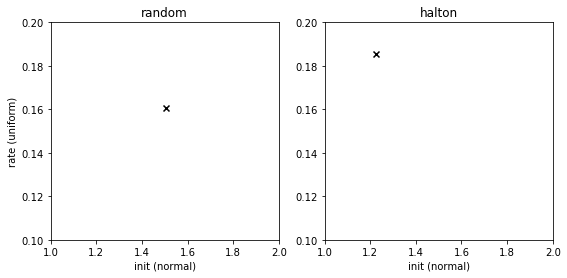

In [3]:
pyplot.rc("figure", figsize=[9, 4])

for fig_idx, rule in enumerate(rules, start=1):
    pyplot.subplot(1, 2, fig_idx)
    
    x_coors, y_coors = samples[rule][:, 100]
    pyplot.scatter(x_coors, y_coors, marker="x", color="k")
    
    pyplot.xlabel("init (normal)")
    pyplot.ylabel("rate (uniform)") if fig_idx == 1 else None
    pyplot.axis([1, 2, 0.1, 0.2])
    pyplot.title(rule)
    
pyplot.show()

### Evaluating model predictor

Creating model predictions is fairly straight forward.
Just note that the (random) samples generated has shape `(len(distribution), number_of_samples)`.
As such, it is important to transpose when iterating over samples to get one evaluation per sample.
In practice:

In [4]:
evaluations = {}
for rule in samples: 
    evals = [exponential_model(sample)
             for sample in samples[rule].T]
    evaluations[rule] = numpy.array(evals)

assert evaluations["random"].shape == (number_of_samples, len(coordinates))
assert evaluations["halton"].shape == (number_of_samples, len(coordinates))

These model evaluations can be visualized. For example by plotting out 50 first the model evaluations for the two schemes.

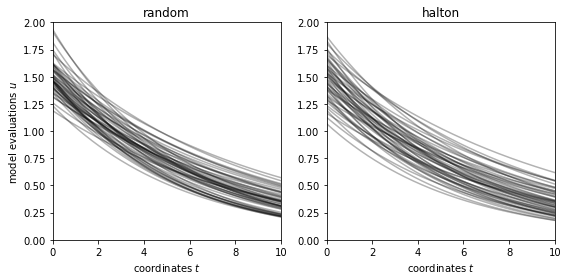

In [5]:
for idx, rule in enumerate(rules, start=1):
    pyplot.subplot(1, 2, idx)
    
    # Make a plot line for the first 50 evaluations
    for evals in evaluations[rule][:50]:
        pyplot.plot(coordinates, evals, "k-", alpha=0.3)
    pyplot.xlabel("coordinates $t$")
    pyplot.ylabel("model evaluations $u$") if idx == 1 else None
    pyplot.title(rule)
    pyplot.axis([0, 10, 0, 2])

pyplot.show()

Though there is some noticable difference in the output, it is hard to asses the difference in performence between the two schemes with the naked eye.

### Assess Statistics

While solving statistics problems analytically by hand, it might be possible to calculate statistical property analytically using the mathematical definitions. In Monte Carlo integration however, such tools are never available. Instead one relies on the assumption that calculating statistical properties using empirical measurements is a good approximation for the analytical counterparts. For example, the expected value and variance can be estimated using sample mean and sample variance.

$$
        \mbox E(U) \approx \bar U = \tfrac 1N \sum_{n=1}^N U_n \qquad
        \mbox{Var}(U) \approx \tfrac 1{N-1} \sum_{n=1}^N \left(U_n - \bar U_n\right)^2
$$

Which numerically becomes:

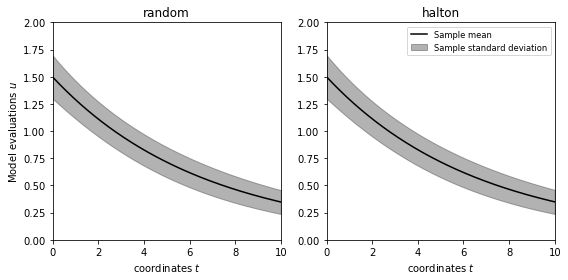

In [6]:
for fig_idx, rule in enumerate(rules, start=1):
    
    pyplot.subplot(1, 2, fig_idx)
    
    # Sample mean and variance
    smean = numpy.mean(evaluations[rule], axis=0)
    svar = numpy.var(evaluations[rule], axis=0)

    # Create band one standard deviation away from mean 
    pyplot.fill_between(coordinates, smean-numpy.sqrt(svar),
                        smean+numpy.sqrt(svar), alpha=0.3,
                        color="k", label="Sample standard deviation")
    pyplot.plot(coordinates, smean, "k-", label="Sample mean")

    # Make plot pretty
    pyplot.xlabel("coordinates $t$")
    pyplot.axis([0, 10, 0, 2])
    pyplot.title(rule)
    if fig_idx == 1:
        pyplot.ylabel("Model evaluations $u$")
    else:
        pyplot.legend()
    
pyplot.show()

### Error Analysis

Having a good estimate on the statistical properties allows us to asses the properties of the uncertainty in the model. However, it does not allow us to assess the accuracy of the methods used. To do that we need to compare the statistical metrics with their analytical counterparts.
To do so, we use the reference analytical solution and error function as defined in  [example introduction](../example_introduction.ipynb).

In [7]:
# NBVAL_CHECK_OUTPUT
from chaospy.example import error_mean, error_variance

(error_mean(smean).round(10),
 error_variance(svar).round(11))

(5.11571e-05, 9.97905e-06)

To illustrate the difference in a common format, we plot error as a function of the number of samples.
Because the error drops fast, the scale used is logarithmic.

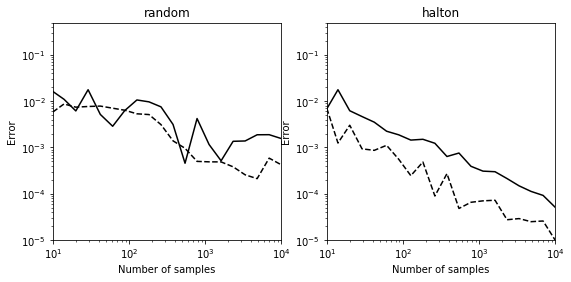

In [8]:
sizes = (10**numpy.linspace(1, 4, 20)).astype(int)

estimated_mean = {"halton": [], "random": []}
estimated_var = {"halton": [], "random": []}
for rule in rules: 
    for size in sizes:
        estimated_mean[rule].append(
            numpy.mean(evaluations[rule][:size], axis=0))
        estimated_var[rule].append(
            numpy.var(evaluations[rule][:size], axis=0))

for fig_idx, rule in enumerate(rules, start=1):
    pyplot.subplot(1, 2, fig_idx)
    
    # error plot for mean
    errors = [error_mean(mean)
              for mean in estimated_mean[rule]]
    pyplot.loglog(sizes, errors, "k-", label="mean")
    
    # error plot for variance
    errors = [error_variance(variance)
              for variance in estimated_var[rule]]
    pyplot.loglog(sizes, errors, "k--", label="variance")
    
    pyplot.axis([10, 10000, 1e-5, 5e-1])
    pyplot.title(rule)
    pyplot.xlabel("Number of samples")
    pyplot.legend() if idx == 1 else pyplot.ylabel("Error")
    
pyplot.show()

As expected, the error when using the Halton sequence converges towards 0 quite a bit faster than wehn using the pseudo-random samples.

### Comparing Different Sample Schemes

So far only `random` and `halton` has been compared. In `chaospy` there are many sampling schemes.
They are as follow:

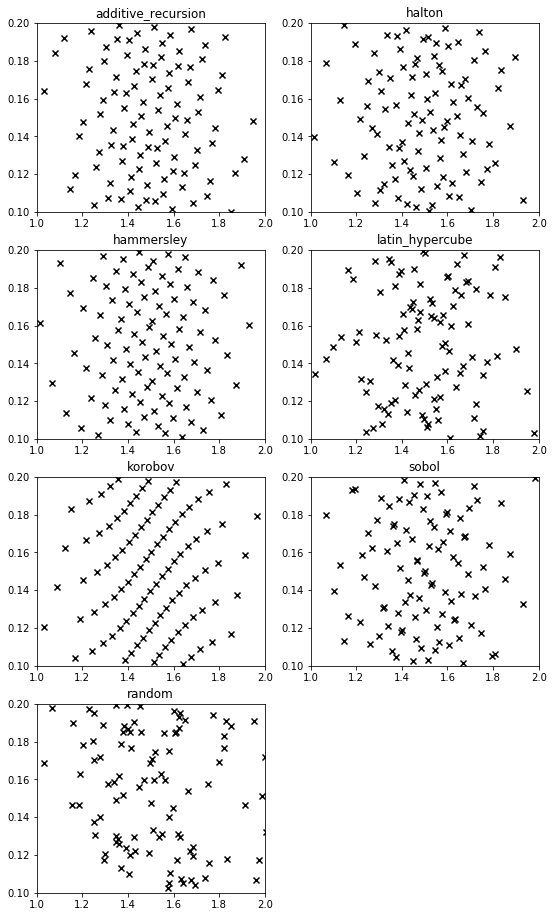

In [9]:
pyplot.rc("figure", figsize=[9, 16])
pyplot.rc("figure.subplot", hspace=0.2)
sampling_rules = ["additive_recursion", "halton", "hammersley",
                  "latin_hypercube", "korobov", "sobol", "random"]

for idx, rule in enumerate(sampling_rules, start=1):
    pyplot.subplot(4, 2, idx)
    
    samples = distribution.sample(100, rule=rule)
    pyplot.scatter(*samples, marker="x", color="k")
    pyplot.axis([1, 2, 0.1, 0.2])
    pyplot.title(rule)
    
pyplot.show()

For a fix number of point, it is possible to compare the different schemes against each other. For example:

In [10]:
# NBVAL_CHECK_OUTPUT
for rule in sampling_rules:
    samples = distribution.sample(1000, rule=rule)
    evals = numpy.array([exponential_model(sample)
                         for sample in samples.T])
    errm = error_mean(numpy.mean(evals, axis=0))
    errv = error_variance(numpy.var(evals, axis=0))
    print(f"{rule:<20} {errm:.6f} {errv:.6f}")

additive_recursion   0.000210 0.000198
halton               0.000272 0.000127
hammersley           0.000608 0.000350
latin_hypercube      0.000192 0.000334
korobov              0.001730 0.000172
sobol                0.000228 0.000140
random               0.007120 0.000570
